# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'input_files/train.p'
validation_file = 'input_files/valid.p'
testing_file = 'input_files/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set

In [2]:
import numpy as np
import pandas as pd

In [3]:
# Number of examples
n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(np.concatenate((y_train, y_test, y_valid))).size

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes (train + validation + test) =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes (train + validation + test) = 43


Quick check: train, validation, and test sets indeed have the same 43 classes present.

### Exploratory visualization of the dataset

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn.apionly as sns

In [5]:
y_train_series = pd.Series(y_train)
y_valid_series = pd.Series(y_valid)
y_test_series = pd.Series(y_test)

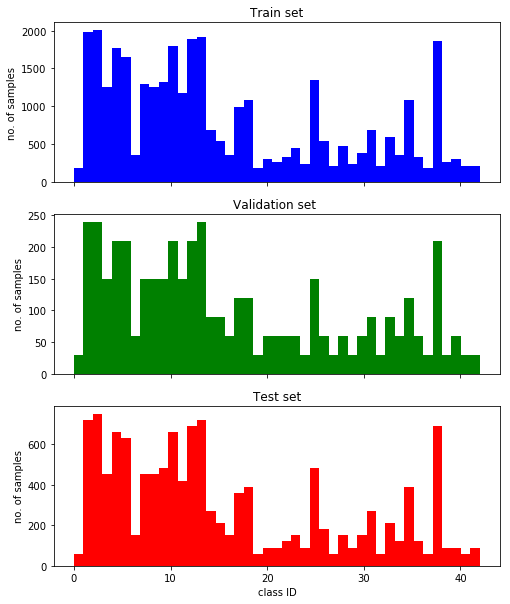

In [6]:
f, axarr = plt.subplots(3, sharex=True, figsize=(8,10))
axarr[0].set_title('Train set')
axarr[0].set_ylabel('no. of samples')
y_train_series.hist(bins=n_classes, grid=False, ax=axarr[0], color='blue')
axarr[1].set_title('Validation set ')
axarr[1].set_ylabel('no. of samples')
y_valid_series.hist(bins=n_classes, grid=False, ax=axarr[1], color='green')
axarr[2].set_title('Test set')
axarr[2].set_ylabel('no. of samples')
axarr[2].set_xlabel('class ID')
y_test_series.hist(bins=n_classes, grid=False, ax=axarr[2], color='red');

Within a given set, certain classes are much more abundant than others: the datasets are highly unbalanced. However, the given train, validation and test sets present a similar composition regarding the proportion of samples for each class. The latter is an important fact to bear in mind when assessing a classifier in a scenario that inherently involves rare classes: validation and test sets should
preserve the percentage of samples for each class for the validation/test scores to be meaningful.

In [7]:
sign_names_df = pd.read_csv('signnames.csv', index_col='ClassId')
sign_names_df['train_samples'] = y_train_series.value_counts()
sign_names_df['valid_samples'] = y_valid_series.value_counts()
sign_names_df['test_samples'] = y_test_series.value_counts()

In [8]:
print('Most common signs in data set:')
sign_names_df.sort_values('train_samples', ascending=False).head()

Most common signs in data set:


,SignName,train_samples,valid_samples,test_samples
ClassId,,,,
2,Speed limit (50km/h),2010,240,750
1,Speed limit (30km/h),1980,240,720
13,Yield,1920,240,720
12,Priority road,1890,210,690
38,Keep right,1860,210,690


In [9]:
print('Least common signs in data set:')
sign_names_df.sort_values('train_samples', ascending=False).tail()

Least common signs in data set:


,SignName,train_samples,valid_samples,test_samples
ClassId,,,,
32,End of all speed and passing limits,210,30,60
27,Pedestrians,210,30,60
37,Go straight or left,180,30,60
19,Dangerous curve to the left,180,30,60
0,Speed limit (20km/h),180,30,60


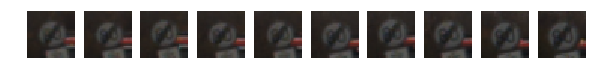

In [10]:
f, axes = plt.subplots(1,10, figsize=(10,10))
axes = axes.flatten()
for i in range(axes.size):
    axes[i].imshow(X_train[y_train == 6][i])
    axes[i].axis('off')

The latter visualization shows that groups of samples represent the same "real world instance", but captured under different conditions (distance, angle, speed, etc.) - corresponding to a changing position of the vehicle with respect to the sign. Therefore, it is very important to shuffle the samples when training the model.

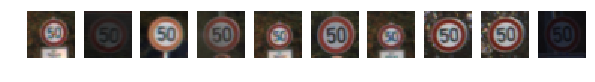

In [11]:
f, axes = plt.subplots(1,10, figsize=(10,10))
axes = axes.flatten()
for i in range(axes.size):
    axes[i].imshow(X_train[y_train == 2][np.random.randint(0, 200)])
    axes[i].axis('off')

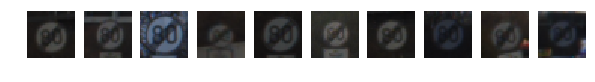

In [12]:
f, axes = plt.subplots(1,10, figsize=(10,10))
axes = axes.flatten()
for i in range(axes.size):
    axes[i].imshow(X_train[y_train == 6][np.random.randint(0, 200)])
    axes[i].axis('off')

As it can be seen, the lighting conditions varies hugely throughout the dataset. Some images can also be blurry due to the vehicle movement, or partially ocluded by surrounding elements.

----
## Step 2: Design and Test a Model Architecture

### Pre-processing of the Data Set 

In [13]:
from skimage import color
from skimage import transform

The preprocessing of the dataset will consist of:
+ Conversion to grayscale: research by [Sermanet & LeCun](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) suggests that models using luminance solely outperform those using RGB channels.
+ [0, 1] normalization: convenient for convergence of the gradient descent algorithm while training.
+ per-sample mean substracion: this normalization has the property of removing the average brightness (intensity) of the data point. In this case, we are not interested in the illumination conditions of the image, but more so in the content.

In [14]:
def preprocess_image_set(data):
    # convert image from RGB to grayscale
    # equivalent to computing luminance or Y channel
    # output from rgb2gray is already [0, 1] scaled
    data = color.rgb2gray(data)
    
    # per-example mean substraction
    data = data - data.mean(axis=(1,2))[:,np.newaxis,np.newaxis]

    return data[:,:,:,np.newaxis]

In [15]:
X_train_orig = X_train.copy()
X_train = preprocess_image_set(X_train)
X_valid = preprocess_image_set(X_valid)

Some random samples after preprocessing:

In [16]:
n_show = 15
image_ix = np.random.randint(0, X_train.shape[0], n_show)

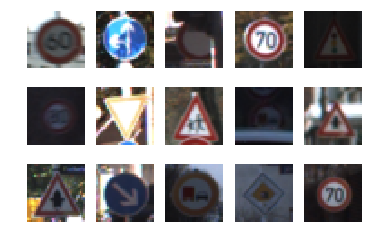

In [17]:
f, axes = plt.subplots(3,5)
axes = axes.flatten()
for i in range(n_show):
    axes[i].imshow(
        X_train_orig[image_ix[i]].reshape(32,32, 3))
    axes[i].axis('off')

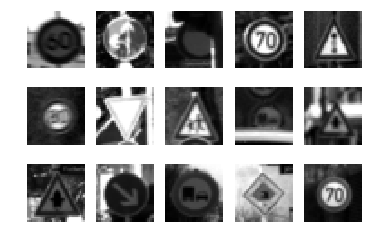

In [18]:
f, axes = plt.subplots(3,5)
axes = axes.flatten()
for i in range(n_show):
    axes[i].imshow(
        X_train[image_ix[i]].reshape(32,32), 
        cmap='gray')
    axes[i].axis('off')

In [19]:
def rotate(X_inp, max_delta=30.0, intensity=1.0):
    delta = max_delta * intensity
    res = [
        transform.rotate(
            X_inp[i], 
            np.random.uniform(-delta, delta), 
            mode='edge'
        ) for i in range(X_inp.shape[0])
    ]
    return np.array(res) 

In [20]:
def apply_affine_transform(X, max_rot=20, max_shear=10, max_shift=2, intensity=1.0):
    image_size = X.shape[1]
    rot = max_rot * np.pi/180 * intensity
    shear = max_shear * np.pi/180 * intensity
    res = list()
    for i in range(X.shape[0]):
        tr = transform.AffineTransform(
            rotation=np.random.uniform(-rot, rot),
            shear=np.random.uniform(-shear, shear),
            translation=np.random.randint(-max_shift, max_shift, 2)
            #translation=(0,0)
        )
        res.append(
            transform.warp(X[i], 
                 tr, 
                 output_shape=(image_size, image_size), order = 1))
            
    return np.array(res)

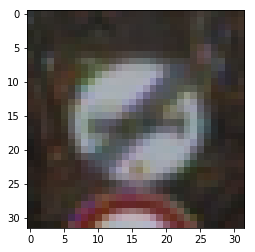

In [21]:
plt.imshow(X_train_orig[65])

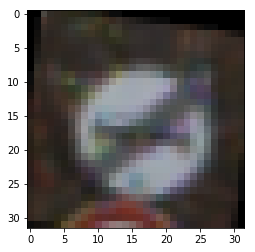

In [22]:
deform_test = apply_affine_transform(X_train_orig)
plt.imshow(deform_test[67])

### Model Architecture

In [23]:
import tensorflow as tf

Here I encapsulate the layers I will use in the model:

In [24]:
def fully_connected(x, n_outputs, l2_reg=0.0):
    # input shape: [n_samples, n_features]
    # weights shape: [n_features, n_outputs]
    # output shape: [n_samples, n_outputs]
    weights = tf.get_variable('weights', 
        shape = [x.get_shape()[1], n_outputs],
        initializer = tf.contrib.layers.xavier_initializer(),
        regularizer = tf.contrib.layers.l2_regularizer(0.0)
      )
    biases = tf.get_variable('biases',
        shape = [n_outputs],
        initializer = tf.constant_initializer(0.0)
      )
    return tf.matmul(x, weights) + biases

def fully_connected_relu(x, n_outputs, l2_reg=0.0):
    return tf.nn.relu(fully_connected(x, n_outputs, l2_reg))

def conv_relu(x, kernel_size, depth, padding='VALID'):
    # input shape: [n_samples, height, width, input_depth]
    # filter weights shape: [ksize, ksize, input_depth, output_depth]
    weights = tf.get_variable('weights', 
        shape = [kernel_size, kernel_size, x.get_shape()[3], depth],
        initializer = tf.contrib.layers.xavier_initializer_conv2d()
      )
    biases = tf.get_variable('biases',
        shape = [depth],
        initializer = tf.constant_initializer(0.0)
      )
    conv = tf.nn.conv2d(x, weights,
        strides = [1, 1, 1, 1], padding=padding)
    return tf.nn.relu(conv + biases)

def pool(x, size, padding='VALID'):
    return tf.nn.max_pool(
        x, 
        ksize=[1, size, size, 1], 
        strides=[1, size, size, 1], 
        padding=padding
    )

I implement a 2-stage ConvNet connected to a 2-layer fully connected classifier, following a multi-scale feature (MS) architecture:

![title](examples/architecture.jpg)

In [25]:
def sermanet_grayscale(x, params, is_training):
    # x (input data) shape: [n_samples, height, width, n_channels]
    # params: Parameters namedtuple containing model parameters
    # is_training: tf.bool flag indicating if we are training or not, to use dropout or not

    ### Convolutions
    
    with tf.variable_scope('conv1'):
        conv1 = conv_relu(x, 
                          kernel_size=params.conv1_k,
                          depth = params.conv1_d
                         ) 
        pool1 = pool(conv1, size=2)
        # only apply dropout if training!
        pool1 = tf.cond(is_training, 
                        lambda: tf.nn.dropout(pool1, keep_prob=params.conv1_p), 
                        lambda: pool1)
        
    with tf.variable_scope('conv2'):
        conv2 = conv_relu(pool1,
                          kernel_size=params.conv2_k, 
                          depth=params.conv2_d
                         )
        pool2 = pool(conv2, size=2)
        # only apply dropout if training!
        pool2 = tf.cond(is_training, 
                        lambda: tf.nn.dropout(pool2, keep_prob=params.conv2_p), 
                        lambda: pool2)

    ### Fully connected
    
    # 1st stage bypassed output
    pool1 = pool(pool1, size=4)
    
    # flatten and concatenate features to be plugged into dense layer
    flattened_1 = tf.contrib.layers.flatten(pool1)
    flattened_2 = tf.contrib.layers.flatten(pool2)
    flattened = tf.concat([flattened_1, flattened_2], 1)

    with tf.variable_scope('fc1'):
        fc1 = fully_connected_relu(flattened, n_outputs=params.fc1_size, l2_reg=params.fc_l2_reg)
        # only apply dropout if training!
        fc1 = tf.cond(is_training, 
                      lambda: tf.nn.dropout(fc1, keep_prob=params.fc1_p), 
                      lambda: fc1)
        
    with tf.variable_scope('fc2'):
        fc2 = fully_connected_relu(fc1, n_outputs=params.fc2_size, l2_reg=params.fc_l2_reg)
        # only apply dropout if training!
        fc2 = tf.cond(is_training, 
                      lambda: tf.nn.dropout(fc2, keep_prob=params.fc2_p), 
                      lambda: fc2)
        
    with tf.variable_scope('out'):
        logits = fully_connected(fc2, n_outputs=params.num_classes)
        
    return logits

In [26]:
model = sermanet_grayscale

Parameter definition:

In [27]:
from collections import namedtuple

Parameters = namedtuple('Parameters', [
        # Data parameters
        'num_classes',
        # Layers architecture
        'conv1_k', 'conv1_d', 'conv1_p', 
        'conv2_k', 'conv2_d', 'conv2_p', 
        'fc1_size', 'fc1_p',
        'fc2_size', 'fc2_p',
        'fc_l2_reg'
    ])

params = Parameters(
    num_classes=43,
    conv1_k=5, conv1_d=30, conv1_p=0.9,
    conv2_k=5, conv2_d=60, conv2_p=0.8,
    fc1_size=100, fc1_p=0.5,
    fc2_size=100, fc2_p=0.5,
    fc_l2_reg=1e-4
)

Similar parameter values to these have been proven to have a good performance in traffic sign classification ([Sermanet et al.](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)). 

Also, dropout was applied to all the layers of the network, with increasing dropout percentages towards the output as suggested by [Hinton et al.](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)

### Train, Validation and Test of the Model

In [28]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
is_training = tf.placeholder(tf.bool)

In [29]:
rate = 0.001

logits = model(x, params, is_training)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


In [30]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, sess):
    num_examples = len(X_data)
    total_accuracy = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={
            x: batch_x, 
            y: batch_y,
            is_training: False
        })
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [31]:
from sklearn.utils import shuffle

EPOCHS = 20
BATCH_SIZE = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    max_score = 0
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={
                x: batch_x, 
                y: batch_y,
                is_training: True
            })
            
        training_accuracy = evaluate(X_train, y_train, sess)
        validation_accuracy = evaluate(X_valid, y_valid, sess)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        if validation_accuracy > max_score:
            max_score = validation_accuracy
            saver.save(sess, './lenet')
            print('Best score so far: model saved')
        print()

Training...

EPOCH 1 ...
Validation Accuracy = 0.608
Training Accuracy = 0.678
Best score so far: model saved

EPOCH 2 ...
Validation Accuracy = 0.838
Training Accuracy = 0.879
Best score so far: model saved

EPOCH 3 ...
Validation Accuracy = 0.905
Training Accuracy = 0.942
Best score so far: model saved

EPOCH 4 ...
Validation Accuracy = 0.915
Training Accuracy = 0.952
Best score so far: model saved

EPOCH 5 ...
Validation Accuracy = 0.935
Training Accuracy = 0.965
Best score so far: model saved

EPOCH 6 ...
Validation Accuracy = 0.945
Training Accuracy = 0.981
Best score so far: model saved

EPOCH 7 ...
Validation Accuracy = 0.951
Training Accuracy = 0.987
Best score so far: model saved

EPOCH 8 ...
Validation Accuracy = 0.957
Training Accuracy = 0.988
Best score so far: model saved

EPOCH 9 ...
Validation Accuracy = 0.960
Training Accuracy = 0.992
Best score so far: model saved

EPOCH 10 ...
Validation Accuracy = 0.961
Training Accuracy = 0.992
Best score so far: model saved

EPOCH 

---

## Step 3: Test a Model on New Images

### Assessment on the given test data set

Apply preprocessing pipeline to the given test set images:

In [32]:
X_test = preprocess_image_set(X_test)

In [33]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test, sess)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.952


### Load and Output the new Images

In [34]:
from skimage import io
downloaded_test_images = [('test%i.JPG' % i) for i in range(1,9)]

In [35]:
dl_test = np.array(
    [io.imread('examples/' + file) for file in downloaded_test_images]
)

y_dl_test = np.array([1, 14, 28, 30, 11, 13, 12, 1])

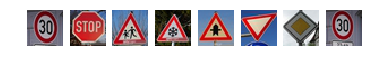

In [36]:
f, axes = plt.subplots(1, 8)
axes_f = axes.flatten()
for i in range(8):
    axes_f[i].imshow(dl_test[i])
    axes_f[i].axis('off')

### Predict the Sign Type for Each Image

In [37]:
X_dl_test = preprocess_image_set(dl_test)

In [38]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    res = sess.run(
        tf.argmax(logits, 1), 
        feed_dict={
            x: X_dl_test, 
            is_training: False})
    print('Predicted Outputs: %s' % res)
    print('Real Outputs:      %s' % y_dl_test)

INFO:tensorflow:Restoring parameters from .\lenet
Predicted Outputs: [ 1 14 28 30 11 13 12  1]
Real Outputs:      [ 1 14 28 30 11 13 12  1]


### Analyze Performance

In [39]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Test Accuracy = {:.3f}".format(evaluate(X_dl_test, y_dl_test, sess)))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [40]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax = tf.nn.softmax(logits)
    top_5_probs = tf.nn.top_k(softmax, k=5)
    res = sess.run(
        top_5_probs, 
        feed_dict={
            x: X_dl_test, 
            is_training: False}
    )

INFO:tensorflow:Restoring parameters from .\lenet


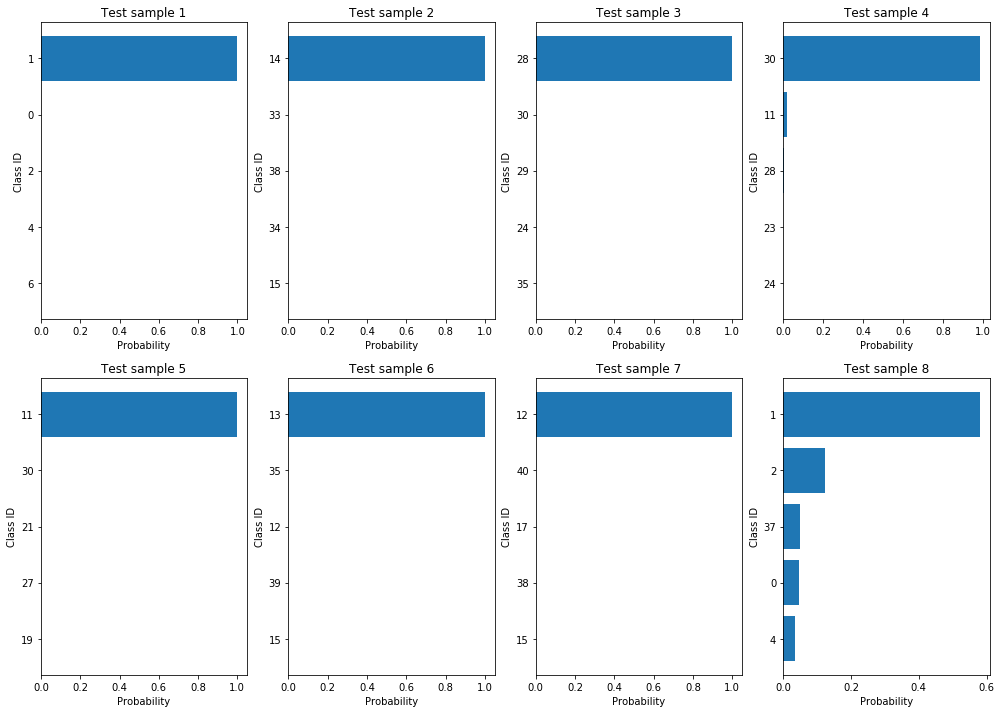

In [41]:
f, axes = plt.subplots(2,4, figsize=(17,12))
axes_f = axes.flatten()
y_pos = np.arange(5)[::-1]
for i in range(8):
    axes_f[i].barh(y_pos, res.values[i], align='center')
    axes_f[i].set_yticks(y_pos)
    axes_f[i].set_yticklabels(res.indices[i])
    axes_f[i].set_ylabel('Class ID')
    axes_f[i].set_xlabel('Probability')
    axes_f[i].set_title('Test sample %i' % (i + 1))

---

## Step 4: Visualize the Neural Network's State with Test Images

In [42]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    activation = tf_activation.eval(session=sess,feed_dict={
        x : image_input,
        is_training: False
    })
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [43]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def firstLayerFilters(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1, interpolation='gaussian'):
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    activation = tf_activation.eval(session=sess,feed_dict={
        x : image_input,
        is_training: False
    })
    act_shape = activation.shape
    featuremaps = act_shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FMap %i' % (featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[:,:,:, featuremap].reshape(act_shape[0], act_shape[1]), 
                       interpolation=interpolation, 
                       vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[:,:,:, featuremap].reshape(act_shape[0], act_shape[1]), 
                       interpolation=interpolation, 
                       vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[:,:,:, featuremap].reshape(act_shape[0], act_shape[1]), 
                       interpolation=interpolation, 
                       vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[:,:,:, featuremap].reshape(act_shape[0], act_shape[1]), 
                       interpolation=interpolation, cmap="gray")

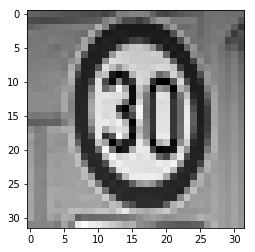

In [44]:
image_input_test = X_dl_test[0].reshape(1,32,32,1)
plt.imshow(image_input_test.reshape(32,32) , cmap='gray');

INFO:tensorflow:Restoring parameters from .\lenet


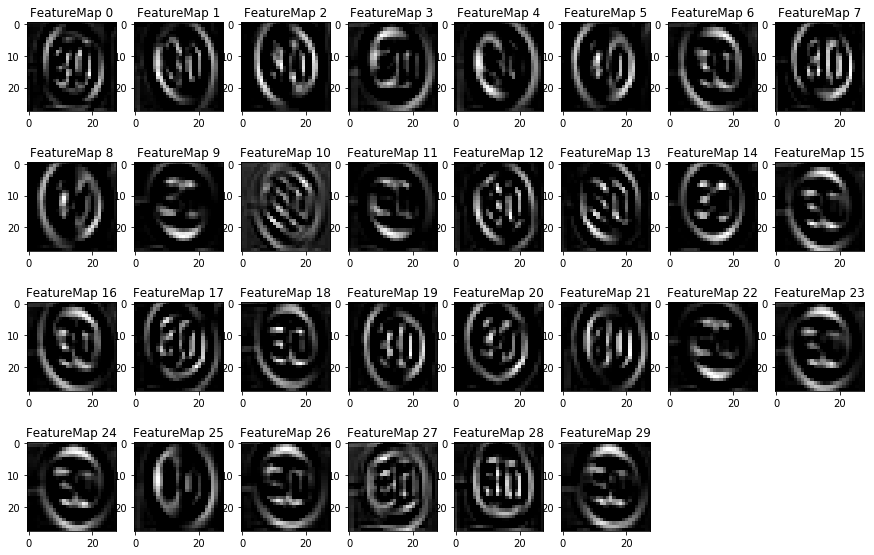

In [45]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(
        image_input_test,
        logits.graph.get_operation_by_name('conv1/Relu').values()[0]
    )

INFO:tensorflow:Restoring parameters from .\lenet


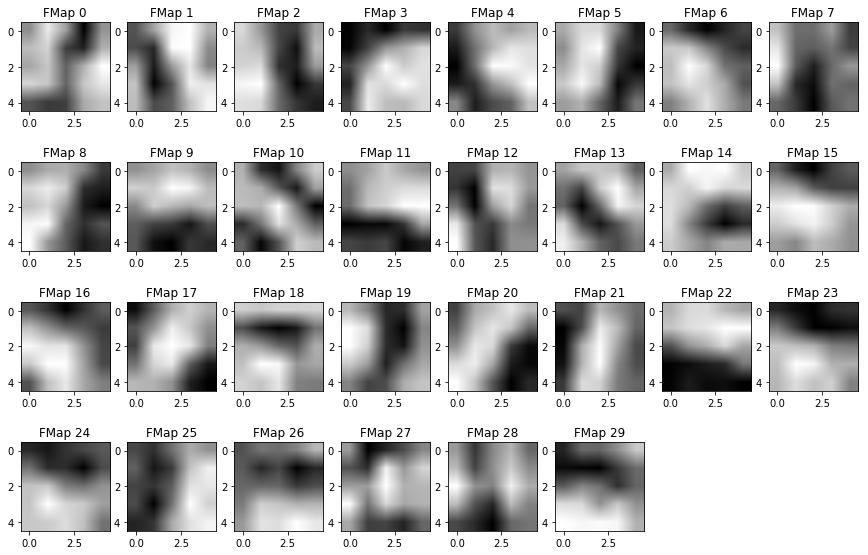

In [46]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    firstLayerFilters(
        image_input_test,
        logits.graph.get_operation_by_name('conv1/weights').values()[0],
        interpolation='bilinear'
    )